In [70]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
from datetime import datetime

from scipy.optimize import minimize, rosen, rosen_der

## Group Assignment
### Team Number: 06
### Team Member Names: Shayan Jalali, Krish Suryavanshi, Paul Reddy
### Team Strategy Chosen: Market Meet

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

## Ticker Filtering

The code below contains the logic used to clean and filter the raw tickers before building the portfolio. 

* We begin by importing a list of tickers from a CSV file. We first check whether each ticker has any historical data available in the specified date range. Only tickers with non-empty price data are retained.

* Next, we check if they are liquid. Illiquid stocks produce unreliable return estimates and unrealistic trading behavior, so we check for a minimum average daily trading volume of 5,000 shares. A month with fewer than 18 trading days is not considered representative and is excluded from the calculation.

* Once the valid months are identified, we calculate the stock’s average daily volume using only the trading days from these months. If the resulting average volume is at least 5,000 shares, the ticker is accepted; otherwise, it is removed.

Finally, we construct a DataFrame of daily closing prices for all tickers that passed both screens.

In [55]:
# Krish's code

csv_file = "Tickers_Example.csv"
tickers = pd.read_csv(csv_file, header=None, names=["Ticker"])

# Include only valid US and Canadian companies that have listed stocks in these markets.

start_date = "2024-10-01"
end_date = "2025-10-01" # TO INCLUDE SEPT 30TH

valid_tickers = []

for ticker in tickers["Ticker"]:
    hist = yf.Ticker(ticker).history(start=start_date, end=end_date)
    
    if not hist.empty:
        valid_tickers.append(ticker)

# Exclude any stock with average daily volume < 5,000 shares between Oct 1, 2024 and Sep 30, 2025 (drop months with < 18 trading days).

volume_cutoff = 5000
minimum_trading_days = 18
final_tickers = []

for valid_ticker in valid_tickers:

    hist = yf.Ticker(valid_ticker).history(start=start_date, end=end_date)
    months = list(hist.index.strftime("%Y-%m"))

    unique_months = []
    for month in months:
        if month not in unique_months:
            unique_months.append(month)
    
    good_months = []
    for unique_month in unique_months:
        if months.count(unique_month) >= minimum_trading_days:
            good_months.append(unique_month)
    
    mask = hist.index.strftime("%Y-%m").isin(good_months)
    filtered_hist = hist[mask]

    avg_volume = filtered_hist["Volume"].mean()
    if avg_volume >= volume_cutoff:
        final_tickers.append(valid_ticker)

# create closing prices DataFrame for the filtered tickers

close_prices = pd.DataFrame()
for final_ticker in final_tickers:
    hist = yf.Ticker(final_ticker).history(start=start_date, end=end_date)
    close_prices[final_ticker] = hist["Close"]

close_prices.index = close_prices.index.strftime("%Y-%m-%d")

close_prices

$CELG: possibly delisted; no timezone found
$MON: possibly delisted; no timezone found
$RTN: possibly delisted; no timezone found


,AAPL,ABBV,ABT,ACN,AGN.CN,AIG,AMZN,AXP,BA,BAC,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-01,224.944046,188.798172,110.925453,345.618683,0.0800,71.177109,185.130005,265.044769,154.220001,38.318249,...,162.130707,160.253296,105.980003,21.057085,81.035965,193.983368,570.918274,239.846222,123.182961,42.547165
2024-10-02,225.510849,188.663986,111.003593,349.850769,0.0800,70.912834,184.759995,267.334076,152.889999,38.328014,...,164.614792,159.121506,106.830002,20.899042,80.413269,195.744202,579.737061,237.697342,122.942627,42.346203
2024-10-03,224.407043,187.350739,109.626320,354.711304,0.0800,70.805168,181.960007,265.034912,150.520004,38.347557,...,165.201584,157.817062,105.980003,20.713108,80.941620,194.050720,580.167664,235.040527,120.825966,42.087822
2024-10-04,225.530716,186.238800,110.026802,355.693237,0.0825,74.436455,186.509995,273.028839,155.000000,39.187782,...,165.182022,159.409256,111.910004,20.555063,81.620934,195.051437,578.650574,233.311615,121.315834,42.776840
2024-10-07,220.449326,185.586990,110.730095,350.351532,0.0800,72.077583,180.800003,270.872040,155.910004,39.041233,...,163.265167,159.121506,110.190002,20.601547,82.017197,193.665817,571.172729,231.367828,121.269623,42.556736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-24,252.065643,218.415421,133.297256,239.080002,0.0700,77.900002,220.210007,339.619476,215.100006,51.700001,...,173.550003,203.245789,206.839996,21.969999,107.572151,182.808289,351.809998,230.360001,82.466415,48.657986
2025-09-25,256.621216,216.975800,132.719818,232.559998,0.0700,77.099998,218.149994,339.320221,213.529999,51.849998,...,169.679993,202.332642,199.960007,21.820000,108.929314,180.429520,345.559998,232.000000,81.168968,48.509575
2025-09-26,255.212601,219.030991,132.958771,238.970001,0.0700,77.980003,219.779999,340.816437,221.259995,52.209999,...,169.199997,202.114273,195.399994,21.830000,109.315651,182.917328,344.079987,235.199997,82.289490,48.915222


## Benchmark Construction and Distance Calculation

In this section, we construct the benchmark average used to evaluate how closely each stock tracks the S&P 500 and TSX.

* We get daily closing prices for both indices over the selected timeframe. From these prices, we compute daily percentage returns and then convert them into cumulative total return series. 

* Next, we take the simple average of the cumulative return series of the S&P 500 and the TSX.

* Finally, we calculate the cumulative total returns of every filtered stock in our dataset. We then merge each stock’s cumulative return series with the benchmark. For each stock, we compute the average absolute distance between its cumulative return curve and the cumulative return of the benchmark. 
  * This metric indicates how closely a stock tracks the S&P and TSX.

The final output is a sorted table of tickers ranked by their average distance from the benchmark. This ranking can be used to identify stocks with low tracking error or to construct diversified yet benchmark-aligned portfolios.



$$
\begin{align*}
\text{Let:} \quad & R_t^{\text{SP}} = \text{cumulative return of S\&P 500} \\
& R_t^{\text{TSX}} = \text{cumulative return of TSX} \\
& R_t^j = \text{cumulative return of stock $j$} \\[1mm]
\text{Benchmark Average:} \quad & B_t = \frac{R_t^{\text{SP}} + R_t^{\text{TSX}}}{2} \\
\text{Distance Between Stock and Benchmark:} \quad & D_j = \frac{1}{T} \sum_{t=1}^{T} \big| R_t^j - B_t \big|
\end{align*}
$$



In [56]:
# Paul's code

#Get the history of the S&P500 and TSX
sp_data = yf.Ticker("^GSPC").history(start=start_date, end=end_date)
tsx_data = yf.Ticker("^GSPTSE").history(start=start_date, end=end_date)
sp_close = sp_data["Close"]
tsx_close = tsx_data["Close"]

#Calculate cumulative total returns 
sp_returns = sp_close.pct_change()
tsx_returns = tsx_close.pct_change()
sp_total_return = sp_returns.cumsum()*100
tsx_total_return = tsx_returns.cumsum()*100

#Average
benchmark_avg = (sp_total_return + tsx_total_return) / 2

#Store them in dataframes
sp_df = pd.DataFrame({"S&P500 TotalReturn": sp_total_return})
tsx_df = pd.DataFrame({"TSX TotalReturn": tsx_total_return})
benchmark_df = pd.DataFrame({"Benchmark Average": benchmark_avg})

benchmark_df.index = benchmark_df.index.strftime("%Y-%m-%d")

print("Benchmark Average:")

#Calculate cumulative total returns for stocks
stock_returns = close_prices.pct_change()
stock_total_returns = stock_returns.cumsum() * 100


#Merge the returns of the stocks and the benchmark average
merged = pd.merge(stock_total_returns, benchmark_df, on="Date", how="inner")

#Store the average distances between the returns of the stock to the returns of the benchmark average in a distances dataframe
distances_dict = {}
for ticker in close_prices.columns:
    avg_distance = (merged[ticker] - merged["Benchmark Average"]).abs().mean()
    distances_dict[ticker] = avg_distance

distances_df = pd.DataFrame(list(distances_dict.items()), columns=["Ticker", "Average Distance"])
distances_df = distances_df.sort_values(by="Average Distance", ascending=True).reset_index(drop=True)
distances_df

Benchmark Average:


/var/folders/nh/705y7gxx1zzdg6v10psp6v500000gp/T/ipykernel_19950/1661196837.py:28: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = close_prices.pct_change()


,Ticker,Average Distance
0,RY.TO,1.616307
1,BLK,4.284492
2,USB,4.455741
3,AXP,6.072005
4,AIG,6.400784
5,AAPL,6.909027
6,ABT,7.203751
7,ABBV,7.267380
8,QCOM,7.435325
9,T.TO,7.546112


## Visualizing Top 20 Stocks vs Benchmark

This code calculates and plots the average cumulative returns of the top 20 stocks that are closest to the benchmark, based purely on their historical average distance to the benchmark.

The purpose is to illustrate that even if we select stocks that individually track the benchmark closely, their combined average does not exactly replicate the benchmark.
By calculating the mean cumulative return of these top 20 stocks and plotting it against the benchmark, we can observe deviations caused by differences in volatility, correlations, and weighting.

This highlights the limitation of a naive selection strategy based solely on distance and highlights the need for a better optimization method, which will be shown later in the code.

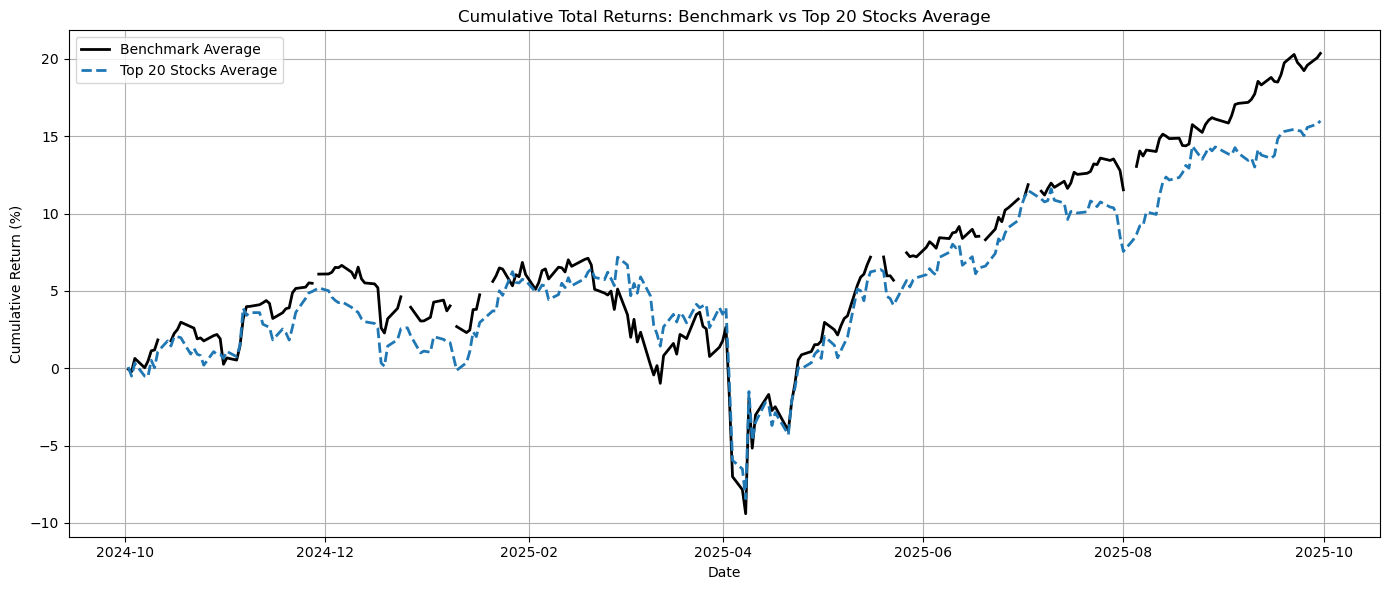

In [73]:
# Select top 20 stocks closest to benchmark
top_20_stocks = distances_df["Ticker"].head(20).tolist()
top_20_returns = stock_total_returns[top_20_stocks]

# average cumulative return of top 20 stocks
top_20_avg_return = top_20_returns.mean(axis=1)

# Convert index to datetime if not already
benchmark_df.index = pd.to_datetime(benchmark_df.index)
top_20_avg_return.index = pd.to_datetime(top_20_avg_return.index)

# Plot cumulative returns
plt.figure(figsize=(14, 6))

# Plot benchmark cumulative returns
plt.plot(benchmark_df.index, benchmark_df["Benchmark Average"], label="Benchmark Average", color="black", linewidth=2)

# Plot top 20 average cumulative return
plt.plot(top_20_avg_return.index, top_20_avg_return, label="Top 20 Stocks Average", color="tab:blue", linestyle='--', linewidth=2)


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.title("Cumulative Total Returns: Benchmark vs Top 20 Stocks Average")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Portfolio Construction

The goal of this code is to construct a well-diversified portfolio of 20 stocks that balances exposure between large-cap and small-cap companies while also ensuring that no single sector dominates the portfolio.

Note: Large-cap stocks are defined as having a market capitalization of at least 10 billion CAD, while small-cap stocks are defined as having a market capitalization below 2 billion CAD. All USD-denominated market capitalizations are converted to CAD
<br>
<br>

* The code identifies all available large-cap and small-cap stocks using the pre-ranked `distances_df` dataframe, which orders stocks by how closely they track the benchmark average.

* Before selecting the remaining stocks, the algorithm forces the inclusion of one large-cap and one small-cap stock to guarantee minimum diversification. Their sectors are recorded.

* The algorithm then iterates through the ranked list of stocks and adds additional candidates while ensuring that no sector exceeds 40% of the portfolio.  
  * If adding a stock would cause a sector to exceed this threshold, it is skipped.

* For every selected stock, the code retrieves its sector, converts the market capitalization into CAD, and classifies it as large-cap, mid-cap, or small-cap. This information is stored in a DataFrame, forming the basis of the final portfolio structure.
<br>
<br>

Before finalizing the portfolio, the code verifies that all constraints are satisfied:  
* There must be at least one large-cap and one small-cap stock,  
* No sector may exceed 40% of the portfolio size.

If any of these conditions are not met, the code raises an error or outputs a warning and does not finalize the portfolio.  
If all constraints are satisfied, the portfolio composition is displayed, including the count of large-cap and small-cap stocks and the distribution of sectors.



In [57]:
# Shayan's code portfolio construction 

# get live USD/CAD exchange rate
exchange_rate_ticker = yf.Ticker("CAD=X")
exchange_rate_data = exchange_rate_ticker.history(period="1d")
exchange_rate = exchange_rate_data['Close'].iloc[-1]
print(f"Current USD/CAD exchange rate: {exchange_rate}")

# categorize all available stocks by market cap
temp_large = []
temp_small = []

for ticker in distances_df['Ticker']:
    try:
        stock = yf.Ticker(ticker)
        mc = stock.info.get('marketCap', 0)
        curr = stock.info.get('currency', 'USD')
         
        mc_cad = mc * exchange_rate if curr == 'USD' else mc
        
        if mc_cad >= 10e9:
            temp_large.append(ticker)
        elif mc_cad < 2e9:
            temp_small.append(ticker)
    except:
        continue

# ensure we have at least 1 large and 1 small
if len(temp_large) == 0 or len(temp_small) == 0:
    raise Exception(f"Cannot meet requirements: found {len(temp_large)} large-cap, {len(temp_small)} small-cap (need at least 1 of each)")

# force 1 large and 1 small into selection
selected_tickers = []
selected_tickers.append(temp_large[0])
selected_tickers.append(temp_small[0])

# get sectors for the 2 already selected
sector_counts_selected = {}
for ticker in selected_tickers:
    try:
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        sector_counts_selected[sector] = sector_counts_selected.get(sector, 0) + 1
    except:
        pass

# fill remaining slots with best trackers respecting 40% sector limit
target_n = 20
max_sector_frac = 0.4

for ticker in distances_df["Ticker"]:
    if ticker in selected_tickers:
        continue
    if len(selected_tickers) >= target_n:
        break
    
    if ticker not in temp_large and ticker not in temp_small:
        continue
    
    try:
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        
        new_total = len(selected_tickers) + 1
        new_sector_count = sector_counts_selected.get(sector, 0) + 1
        new_sector_frac = new_sector_count / new_total
        
        if new_sector_frac > max_sector_frac:
            continue
        
        selected_tickers.append(ticker)
        sector_counts_selected[sector] = new_sector_count
    except:
        continue

print(f"\nSelected {len(selected_tickers)} stocks")
print(f"Large-caps: {len([t for t in selected_tickers if t in temp_large])}")
print(f"Small-caps: {len([t for t in selected_tickers if t in temp_small])}")
print(f"Sector counts: {sector_counts_selected}")

# create stock_info dataframe
ticker_list = []
sector_list = []
market_cap_cad_list = []
cap_type_list = []

for ticker in selected_tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        sector = info.get('sector', 'Unknown')
        market_cap = info.get('marketCap', 0)
        currency = info.get('currency', 'USD')
        
        if currency == 'USD':
            market_cap_cad = market_cap * exchange_rate
        else:
            market_cap_cad = market_cap
        
        if market_cap_cad >= 10e9:
            cap_type = 'Large'
        elif market_cap_cad < 2e9:
            cap_type = 'Small'
        else:
            cap_type = 'Mid'
        
        ticker_list.append(ticker)
        sector_list.append(sector)
        market_cap_cad_list.append(market_cap_cad)
        cap_type_list.append(cap_type)
    except:
        continue

stock_info = pd.DataFrame({
    'Ticker': ticker_list,
    'Sector': sector_list,
    'MarketCap_CAD': market_cap_cad_list,
    'CapType': cap_type_list
})

print("\n", stock_info)

Current USD/CAD exchange rate: 1.409000039100647

Selected 20 stocks
Large-caps: 19
Small-caps: 1
Sector counts: {'Financial Services': 5, 'Healthcare': 4, 'Technology': 3, 'Communication Services': 1, 'Industrials': 3, 'Consumer Cyclical': 1, 'Consumer Defensive': 3}

     Ticker                  Sector  MarketCap_CAD CapType
0    RY.TO      Financial Services   2.933155e+11   Large
1   AGN.CN              Healthcare   2.911778e+06   Small
2     AAPL              Technology   5.567317e+12   Large
3     T.TO  Communication Services   2.916432e+10   Large
4    TD.TO      Financial Services   1.974993e+11   Large
5      TXN              Technology   1.964118e+11   Large
6      CAT             Industrials   3.619060e+11   Large
7     AMZN       Consumer Cyclical   3.270675e+12   Large
8      BAC      Financial Services   5.322559e+11   Large
9       MO      Consumer Defensive   1.377101e+11   Large
10      PG      Consumer Defensive   4.886927e+11   Large
11     UNP             Industrial

## Relationships between the Stocks and the Benchmark

The purpose of the code below is to prepare the data for portfolio optimization by calculating the relationships between the selected stocks and the benchmark.

* Firstly, we extract the daily returns for our selected stocks and calculate benchmark daily returns as the average of the S&P and TSX. Then both datasets are aligned to the common dates

* Using the aligned stock returns, the code calculates a covariance matrix. This matrix is a 20×20 NumPy array where each element represents the covariance between a pair of stocks. This matrix captures how each stock moves relative to every other stock in the portfolio.

Note: While the code is designed to calculate a 20×20 covariance matrix for the selected portfolio of stocks, the actual size of the covariance matrix can vary depending on data availability. Some stocks may have missing return data for certain dates or may be removed during preprocessing steps such as dropping NaN values. As a result, the number of stocks included in the covariance matrix, and therefore its dimensions, may be less than 20×20.


* For each stock, the covariance with the benchmark is computed. These covariances indicate how closely each stock moves with the benchmark.

* Finally, the variance of the aligned benchmark returns is calculated. This measures the daily variability of the benchmark itself.



<div style="text-align: left;">

$$
\begin{align*}
\text{Let } & r_t^j \text{ be the daily return of stock } j \text{ on day } t, \quad j = 1, \dots, 20 \\ 
\text{Let } & r_t^{B} = \frac{r_t^{\text{SP}} + r_t^{\text{TSX}}}{2} \text{ be the benchmark daily return} \\[1mm]
\text{Aligned Returns:} \quad & \text{Consider only dates } t \in \mathcal{T}_{\text{common}} \text{ where both stock and benchmark returns exist} \\[1mm]
\text{Stock Covariance Matrix:} \quad & \Sigma = \Big[ \text{Cov}(r^i, r^j) \Big]_{i,j=1}^{20} \\[1mm]
\text{Covariance with Benchmark:} \quad & \text{cov}_{jB} = \text{Cov}(r^j, r^B), \quad j = 1, \dots, 20 \\[1mm]
\text{Benchmark Variance:} \quad & \sigma_B^2 = \text{Var}(r^B) \\[1mm]
\end{align*}
$$

</div>


<div style="text-align: left;">

The covariance matrix for the selected portfolio is represented symbolically as:

$$
\Sigma =
\begin{bmatrix}
\mathrm{Cov}(r^{1}, r^{1}) & \mathrm{Cov}(r^{1}, r^{2}) & \cdots & \mathrm{Cov}(r^{1}, r^{n}) \\
\mathrm{Cov}(r^{2}, r^{1}) & \mathrm{Cov}(r^{2}, r^{2}) & \cdots & \mathrm{Cov}(r^{2}, r^{n}) \\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{Cov}(r^{n}, r^{1}) & \mathrm{Cov}(r^{n}, r^{2}) & \cdots & \mathrm{Cov}(r^{n}, r^{n})
\end{bmatrix}
$$

Where:

$$
\mathrm{Cov}(r^{i}, r^{j}) = \frac{1}{T-1} \sum_{t=1}^{T} (r_t^{i} - \bar{r}^{i})(r_t^{j} - \bar{r}^{j})
$$

with:

- $r_t^{i}$ : Daily return of stock $i$ on day $t$  
- $r_t^{j}$ : Daily return of stock $j$ on day $t$  
- $\bar{r}^{i}$ : Mean return of stock $i$  
- $\bar{r}^{j}$ : Mean return of stock $j$  
- $T$ : Number of aligned trading days  
- $n$ : Number of stocks included after alignment (typically close to 20)

</div>

In [58]:
# get the daily returns for the selected stocks, and dropping the rows that dont
selected_stock_returns = stock_returns[selected_tickers].dropna()

# gets the benchmark daily returns: going to be useful when using scipy optimization
benchmark_daily_returns = (sp_returns + tsx_returns) / 2

# have to use strftime otherwise get mismatch when comparing to the aligned stock returns index
benchmark_daily_returns.index = benchmark_daily_returns.index.strftime('%Y-%m-%d')

# find the cmommon dates to use with .index intersection() for both the stock returns and benchmark returns (had to alisgn them)
common_dates = selected_stock_returns.index.intersection(benchmark_daily_returns.index)
aligned_stock_returns = selected_stock_returns.loc[common_dates]
aligned_benchmark_returns = benchmark_daily_returns.loc[common_dates]


# using the covariance on alisgned selected stock rteurns to generate matrix
cov_matrix = aligned_stock_returns.cov().values # with the data for now, matrix is 20x20 numpy array with covariances between all pairs of selected stocks
# print(cov_matrix)

# calculate covariances between each stock and the benchmark
stock_benchmark_covariances = []

# for stock in the list of stocks we've filtered out
for ticker in selected_tickers:
    # assign series (1D array) to the common dates of the stock
    stock_returns_series = aligned_stock_returns[ticker]
    # assign series (1D array) to the common dates of the benchmark returns
    benchmark_returns_series = aligned_benchmark_returns

    # calucluate the covariance at that specific point (daily values)
    covariance = stock_returns_series.cov(benchmark_returns_series)
    # add it to stock_benchmark relationship
    stock_benchmark_covariances.append(covariance)

# store as numpy array for scipy on all the covariances that we've appdned to the empty list  before for loop (expects num array and also want consistensy with cov_matrix)
benchmark_cov = np.array(stock_benchmark_covariances)
    
# of the benchmark returns that are aligned with the common dates, how much does it go up and oown daily 
benchmark_var = aligned_benchmark_returns.var()

# print to verify all three covariance components
print("Covariance matrix shape:", cov_matrix.shape) # how the stocks move relative to eadch other 
print("Benchmark covariances length:", len(benchmark_cov)) # how the stocks move with the benchmark
print("Benchmark variance:", benchmark_var) # how the becnhmark moves

Covariance matrix shape: (20, 20)
Benchmark covariances length: 20
Benchmark variance: 9.698255889153165e-05


## Stock-Benchmark Covariances

This bar chart shows how each stock’s returns relate to the benchmark. Higher covariance bars indicate stocks that move with the benchmark, while lower covariance bars move against it. These covariances help guide portfolio weights to minimize tracking error while keeping diversification.

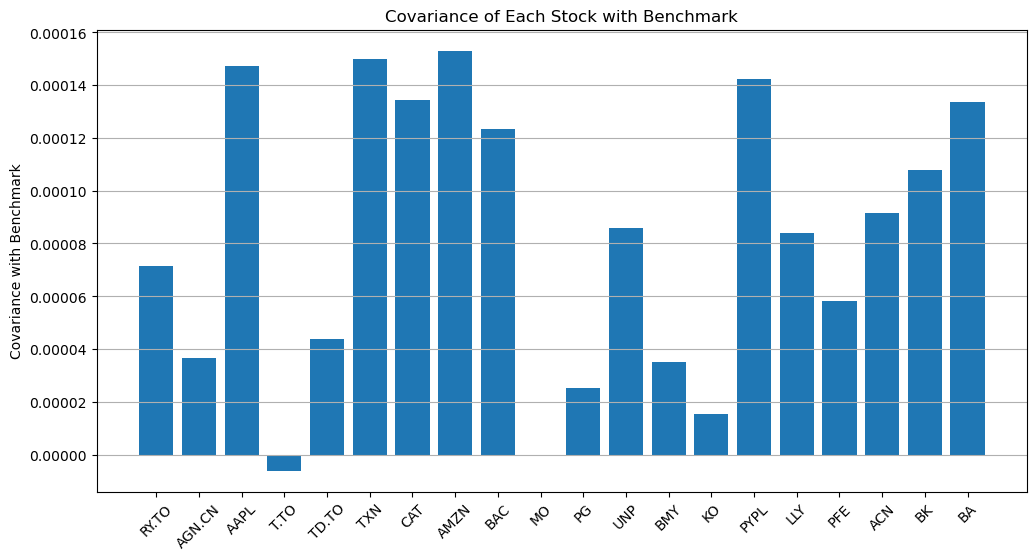

In [78]:
aligned_tickers = aligned_stock_returns.columns

plt.figure(figsize=(12,6))
plt.bar(aligned_tickers, benchmark_cov)
plt.xticks(rotation=45)
plt.ylabel("Covariance with Benchmark")
plt.title("Covariance of Each Stock with Benchmark")
plt.grid(axis='y')
plt.show()

## Portfolio Optimization Using Error Variance Tracking

This code defines and solves a portfolio optimization problem that is based on the concept of tracking error variance. <br>
Tracking error quantifies how much a portfolio’s returns deviate from a benchmark.<br>
By minimizing tracking error, the goal is to construct a portfolio that closely follows the performance of the benchmark while respecting diversification, weighting, and sector constraints.

<br>
<br>

$$
\text{Portfolio Variance:} \quad \sigma_p^2 = \mathbf{w}^\top \Sigma \mathbf{w}
$$

where $\mathbf{w}$ is the vector of portfolio weights. This expression captures how the weighted combination of the selected stocks fluctuates, taking into account both individual stock volatilities and correlations between the stocks. <br>
The inner dot product accounts for how stocks amplify each other’s returns, while the outer product applies the weights to compute the portfolio variance.  
<br>
<br>

$$
\text{Portfolio-Benchmark Covariance:} \quad \text{cov}_{pB} = \mathbf{w}^\top \text{cov}_B
$$

This term measures how the portfolio moves relative to the benchmark. It is a weighted sum of the covariances between each stock and the benchmark, reflecting how the composition of the portfolio affects its alignment with the benchmark.
<br>
<br>

$$
\text{Tracking Error Variance:} \quad \text{TEV} = \mathbf{w}^\top \Sigma \mathbf{w} - 2 \, \mathbf{w}^\top \text{cov}_B + \sigma_B^2
$$

This formula is derived from standard portfolio theory and expresses the variance of the difference between the portfolio return and the benchmark return. <br><br><br>
In addition, the code adds a beta penalty term so that the portfolio can have a beta close to 1 relative to the benchmark:

$$
\text{Beta Penalty:} \quad \text{Penalty} = 500 \cdot (\text{beta} - 1.0)^2, \quad \text{where } \text{beta} = \frac{\mathbf{w}^\top \text{cov}_B}{\sigma_B^2}
$$

This ensures that the portfolio not only minimizes tracking error but also tracks the benchmark directionally.
<br>

In addition to minimizing tracking error, the portfolio must satisfy several constraints:

* The weights must sum to 1 
* Each weight also has a minimum value, defined as $100/(2 \cdot n)$ percent of the portfolio
* Each weight has a maximum value of 15%
* Each sector cannot exceed 40% of the total portfolio weight
<br>

The optimizer requires an initial guess for the portfolio weights. <br>
In this code, the initial weights are distance-based rather than equal:  

* Stocks closer to the benchmark (smaller average distance) receive higher initial weights.  
* The raw scores are normalized to sum to 1.  
* Weights are then clipped to fall within the minimum and maximum bounds, and normalized again to sum to 1.  

This array serves as the starting point (`x0`) for the SLSQP optimizer.
<br>

Finally, the code checks `optimizer_data.success` to ensure the optimization converged. If not, an exception is raised.  

The resulting `optimal_weights` represent the portfolio allocation that:

* Minimizes tracking error relative to the benchmark  
* Maintains a beta close to 1  
* Respects minimum and maximum weights per stock  
* Ensures no sector exceeds 40%  



In [59]:
# Shayan's code

# define function that calculates tracking error variance
# input: weights (array of 20 numbers)
# calculate: portfolio_var = weights^T @ cov_matrix @ weights
# calculate: portfolio_bench_cov = weights^T @ benchmark_cov
# calculate: tracking_error_var = portfolio_var - 2*portfolio_bench_cov + benchmark_var
# return: tracking_error_var

def tracking_error_variance(weights):
    # inner dot product understands how the stocks amplify each other, and outer dot product determines weightages based on this interactions
    portfolio_var = np.dot(weights, np.dot(cov_matrix, weights))
    portfolio_bench_cov = np.dot(weights, benchmark_cov)
    # https://quant.stackexchange.com/questions/35720/ex-ante-tracking-error-active-strategies-and-the-size-of-the-covariance-matrix used this interesting source for calculating tracking error
    tracking_error_var = portfolio_var - 2 * portfolio_bench_cov + benchmark_var

    # calculate portfolio beta and add penalty to encourage beta closer to 1.0 (tracking error does its job but the restrictions maade it have lower beta)
    portfolio_beta = portfolio_bench_cov / benchmark_var
    beta_penalty = 500 * (portfolio_beta - 1.0)**2

    return tracking_error_var + beta_penalty

# constraint 1: all weights must sum to 1 (100%)
# constraint 2: each weight must be >= minimum (100 / (2*n) percent)
# constraint 3: each weight must be <= 0.15 (15%)

num_stocks = len(selected_tickers) # get the number of stocks we selected
min_weight_stocks = (100/(2 * num_stocks)) / 100  # get the minimum weight per stock

# make dict to have each ticker with its sector
sector_lookup = {}
for i in range(len(stock_info)):
    t = stock_info.loc[i, "Ticker"]
    sector_lookup[t] = stock_info.loc[i, "Sector"]

# get each sector with the indexes of its stocks in the weights list
sector_index_map = {}
for i in range(len(selected_tickers)):
    t = selected_tickers[i]
    sector = sector_lookup[t]
    if sector not in sector_index_map:
        sector_index_map[sector] = []
    sector_index_map[sector].append(i)

# define constratints function

# this will verify with scipy that a function returns 0 when constraint is satsiifed 
def weights_must_sum_to_one(weights):
    return np.sum(weights) - 1

constraints = [{'type': 'eq', 'fun': weights_must_sum_to_one}]

# do sector check per sector by summing to get the weight of each sector
for sector in sector_index_map:
    idx_list = sector_index_map[sector]

    def sector_constraint(weights, idx_list=idx_list):
        sector_weight = 0
        for j in idx_list:
            sector_weight = sector_weight + weights[j]
        return 0.40 - sector_weight   # must be >= 0

    constraints.append({'type': 'ineq', 'fun': sector_constraint})

# create bounds list
bounds = []
for ticker in selected_tickers:
# boudns requires (min, max) pairs for each element based on scipy documentation. pairs = tuples also want them to be immutasble
    bounds.append((min_weight_stocks, 0.15))

# create initial_weights arrayz; op[timizer needs a starting point before caluclating based on the bounds which have been made
# x0ndarray, shape (n,)
# Initial guess. Array of real elements of size (n,), where n is the number of independent variables.
# Reqwuired to pass in x0. Basically the initial guess based on scipy documentation

# get distances for the selected tickers in the same order
dist_for_port = distances_df[distances_df["Ticker"].isin(selected_tickers)]
dist_for_port = dist_for_port.set_index("Ticker")

distance_list = []
for t in selected_tickers:
    distance_list.append(dist_for_port.loc[t, "Average Distance"])

distance_array = np.array(distance_list)

# closer to benchmark (small distance) = bigger score
scores = 1.0 / distance_array

# base weights proportional to these scores
scores_sum = scores.sum()
raw_weights = scores / scores_sum # normalize it to 1

clipped_weights = np.clip(raw_weights, min_weight_stocks, 0.15) # .clip allows us to set min and max values

initial_weights = clipped_weights / clipped_weights.sum() # normalize it to 1

# contains everything about how result went based on all the data fed into it
# using SLSQP method because it handles bounds and equality constraints efficiently
# extracts the optimal weights (x attribute) from the optimizer result object
optimizer_data= minimize(tracking_error_variance, initial_weights, method='SLSQP', bounds = bounds, constraints=constraints)

# check for optimization success
if not optimizer_data.success:
    print(f"Optimization failed: {optimizer_data.message}")
    raise Exception("Cannot find valid portfolio weights")


# sintially needed the x0 value, now calling the actual .x value from the optimizer 
optimal_weights = optimizer_data.x

/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [60]:
# Shayan's code

# checks if optimization worked
print("Success:", optimizer_data.success)
print("Tracking error variance:", optimizer_data.fun)
print("Total weight:", np.sum(optimal_weights))

print("\nWeights by stock:")
# make counter variable 
i = 0
# make for loop that itrates over the sleected ticker list
for ticker in selected_tickers:
    # the ticker weightage is the optimal weights index * 100 to convert to percentage for each ticker and then rounds to 2 decimal places
    print(f"{ticker}: {optimal_weights[i]*100:.2f}%")
    i += 1

Success: True
Tracking error variance: 2.3050609807893974e-05
Total weight: 1.0

Weights by stock:
RY.TO: 9.15%
AGN.CN: 2.85%
AAPL: 10.64%
T.TO: 4.43%
TD.TO: 4.31%
TXN: 10.01%
CAT: 3.98%
AMZN: 9.75%
BAC: 3.73%
MO: 3.65%
PG: 3.65%
UNP: 3.57%
BMY: 3.49%
KO: 3.45%
PYPL: 9.30%
LLY: 2.93%
PFE: 2.91%
ACN: 2.76%
BK: 2.76%
BA: 2.72%


In [61]:
# Shayan's code

print(optimal_weights)

[0.09145962 0.02848268 0.10637346 0.04434625 0.04313915 0.10005021
 0.03977304 0.09746385 0.03729382 0.03646324 0.03645272 0.03566303
 0.03485652 0.03451478 0.09296693 0.02928123 0.02908983 0.02757883
 0.0275606  0.0271902 ]


## Portfolio Beta Calculation

This code calculates the beta of the optimized portfolio relative to the benchmark.  
Beta measures the sensitivity of the portfolio's returns to movements in the benchmark, indicating how closely the portfolio tracks the benchmark.
A beta value close to 1 indicates that the portfolio moves in line with the benchmark, while values greater than 1 or less than 1 indicate higher or lower sensitivity, respectively.


In [62]:
# calculate portfolio beta relative to benchmark
# beta measures how much portfolio moves relative to benchmark

# get portfolio returns using optimal weights (use ALIGNED returns)
portfolio_returns = (aligned_stock_returns * optimal_weights).sum(axis=1)

# calculate covariance  between portfolio and benchmark (use ALIGNED benchmark)
portfolio_benchmark_cov = portfolio_returns.cov(aligned_benchmark_returns)

# calculate variance of benchmark (use ALIGNED benchmark)
benchmark_variance = aligned_benchmark_returns.var()

# beta = Cov(portfolio, benchmark) / Var(benchmark)
portfolio_beta = portfolio_benchmark_cov / benchmark_variance

print(f"\nPortfolio Beta: {portfolio_beta}")


Portfolio Beta: 0.9999999623061825


## Post-Optimization Check

This block of code performs essential post-optimization checks to ensure that the final portfolio produced still complies with the constraints. While the optimization process focuses solely on minimizing tracking error, it may generate a set of weights that violate the requirements. Because of this, the code re-evaluates sector and market-cap constraints after optimization.

* The code first constructs a DataFrame (`portfolio_df`) that combines each selected stock with its optimized weight and descriptive information such as its sector and market-cap classification. Using this DataFrame, the code computes the total portfolio weight allocated to each sector by summing the weights per sector. The code prints the sector weights for transparency.

* To verify sector diversification, the code checks whether any sector exceeds the maximum allocation of 40%. A small tolerance (`0.0001`) is included to account for floating-point precision issues. If any sector exceeds 40% + tolerance, the code prints a sector weight violation message. If no sector violates the limit, it prints that there are no sector violations.

* Next, the code checks market-cap diversification. It calculates the total weight assigned to large-cap stocks and the total weight assigned to small-cap stocks. These totals are printed. The portfolio must include at least some weight in both large-cap and small-cap categories to satisfy the diversification requirement. If either total weight is zero, the code prints a market-cap violation message indicating that at least one stock from each category is required.


In [63]:
# for step 5: initial check of like constrains of 40% was to identify if the stocks selected were diverse enoughh
# after optimization, we're going to get weightages htat violate those retsirtcions so redoing the 40% restrictions here will help with ensuring that they fit the constrants
# even if those contsraints make our weightages worse, we have to follow the restrictions 

# krish's code

# make a df for tickers and weights
dict = {"Ticker": selected_tickers, "Weight": optimal_weights}
weights_df = pd.DataFrame(dict)

# create portfolio df
portfolio_df = pd.merge(weights_df, stock_info , on="Ticker", how="inner")

# get sector weights
sector_weights_series = portfolio_df.groupby("Sector")["Weight"].sum()
sector_weights = sector_weights_series.to_dict()

# print them
for sector in sector_weights:
    print(str(sector) + ": " + str(np.round(sector_weights[sector] * 100, 2)) + "%")

print()

# check for sector violations (max 40% in one sector)
sector_violations = False
tolerance = 0.0001  # small tolerance to account for python's precision issues w/ numbers
for sector in sector_weights:
    if sector_weights[sector] > 0.4 + tolerance:
        sector_violations = True
        print("Sector weight violation: " + str(sector) + " is " + str(np.round(sector_weights[sector] * 100, 2)) + "%; max 40%")

if not sector_violations:
    print("No sector weight violations.")

print()

# check for cap violations (need one large cap and one small cap minimum)
large_rows = portfolio_df[portfolio_df["CapType"] == "Large"]
large_weight_total = large_rows["Weight"].sum()

small_rows = portfolio_df[portfolio_df["CapType"] == "Small"]
small_weight_total = small_rows["Weight"].sum()

print("Total Large Cap Weight: " + str(np.round(large_weight_total * 100, 2)) + "%")
print("Total Small Cap Weight: " + str(np.round(small_weight_total * 100, 2)) + "%")
print()

if (not large_weight_total > 0) or (not small_weight_total > 0):
    print("Market cap weight violation; need at least one large cap and one small cap stock")

Communication Services: 4.43%
Consumer Cyclical: 9.75%
Consumer Defensive: 10.74%
Financial Services: 29.24%
Healthcare: 12.17%
Industrials: 10.26%
Technology: 23.4%

No sector weight violations.

Total Large Cap Weight: 97.15%
Total Small Cap Weight: 2.85%



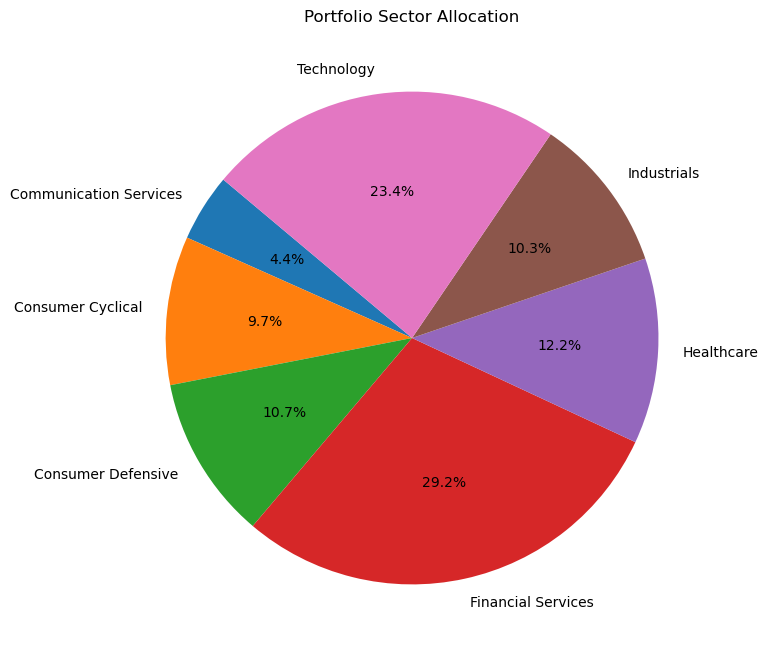

In [80]:
# Pie chart for sector weights
plt.figure(figsize=(8,8))
plt.pie(sector_weights.values(), labels=sector_weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Sector Allocation")
plt.show()


In [64]:
# After the loop, before selected_tickers line:
print(f"Found {len(temp_large)} large caps")
print(f"Found {len(temp_small)} small caps")
print(f"Sector distribution: {sector_counts}")

selected_tickers = temp_large[:15] + temp_small[:5]

Found 36 large caps
Found 1 small caps
Sector distribution: Sector
Communication Services    1
Consumer Cyclical         1
Financial Services        7
Healthcare                3
Industrials               1
Technology                3
dtype: int64


## Getting Prices for the Optimized Portfolio

This code-block collects the most recent available closing price and the corresponding trading currency for each stock in the optimized portfolio.  
It iterates through each row of the `portfolio_df`, fetching historical price data for the past five trading days but only storing the most recent closing price.  
If no price data is available for a ticker, it prints a message and skips that ticker.  
If the currency is not available, it defaults to “Unknown.”  


In [65]:
# Paul's code

#create a dictionary with the ticker and its price and currency so we can convert for fees
price_data = {
    "Ticker": [],
    "Price": [],
    "Currency": []
}

for index, row in portfolio_df.iterrows():
    ticker = row["Ticker"]   

    try:
        stock = yf.Ticker(ticker)

        # get most recent avilable closing price (in this case when the code will fetch Nov 21st)
        hist = stock.history(period="5d")

        if hist.empty:
            print(f"No recent price data for {ticker}")
            continue

        close_price = hist["Close"].iloc[-1]

        # extract currency
        currency = stock.info.get("currency", "Unknown")

        # add row to the df structure
        price_data["Ticker"].append(ticker)
        price_data["Price"].append(close_price)
        price_data["Currency"].append(currency)


    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# convert to DataFrame
prices_df = pd.DataFrame(price_data)

print("\nFinal Prices DataFrame:")
prices_df


Final Prices DataFrame:


,Ticker,Price,Currency
0,RY.TO,207.979996,CAD
1,AGN.CN,0.085000,CAD
2,AAPL,266.250000,USD
3,T.TO,18.840000,CAD
4,TD.TO,114.660004,CAD
5,TXN,153.330002,USD
6,CAT,546.130005,USD
7,AMZN,217.139999,USD
8,BAC,51.000000,USD
9,MO,58.180000,USD


## Transaction-Fee–Adjusted Portfolio Construction

This section of the code is responsible for converting the optimized portfolio weights into actual numbers of shares, converting currencies, transaction fees, and the final scaling of investment amounts. The process begins by merging the portfolio allocation with the price data collected earlier. This merged DataFrame includes each stock’s weight, price, and trading currency.

* Using the optimized weights, the code calculates each stock’s target dollar value before accounting for fees. Since some stocks may trade in USD, the target value is converted into the stock’s currency to ensure correct share calculations.

* Next, the code calculates the number of shares for each stock by dividing the target value by the stock’s market price. Transaction fees are then calculated for every stock:
  * flat USD 2.15 or 
  * 0.1% of the number of shares purchased—whichever is smaller. <br>

  These fees are always denominated in USD, so each fee is converted back to CAD using the exchange rate. The total CAD fees are then summed to determine how much of the initial one million dollars is consumed by transaction costs.

* Since fees reduce the amount that can actually be invested, the code calculates the investable amount remaining after fees and derives a scaling factor representing the proportion of the original budget that remains available. All initial target values are then scaled down using this factor so that the portfolio remains proportional while fitting within the reduced investable amount. After scaling, the code once again converts the adjusted values into the appropriate currency (USD or CAD), recalculates the number of shares, and computes each position’s final value.

Finally, it converts all positions back to CAD, calculates the final weight of each position relative to the total investable amount, and checks the consistency of the resulting portfolio. The process ensures that the final weights sum to 1 (or extremely close) and that the total invested amount matches the adjusted budget after fees.

In [66]:
# calculate shares with transaction fees

# merge prices into portfolio
portfolio_with_prices = pd.merge(portfolio_df, prices_df, on="Ticker", how="inner")

# start with a budget of 1 million CAD
budget_cad = 1000000

# calculate initial target values based on optimal weights
portfolio_with_prices["TargetValue_CAD"] = portfolio_with_prices["Weight"] * budget_cad

# convert prices to CAD if necessary
target_values_stock_currency = []
for index, row in portfolio_with_prices.iterrows():
    if row["Currency"] == "USD":
        target_values_stock_currency.append(row["TargetValue_CAD"] / exchange_rate)
    else:
        target_values_stock_currency.append(row["TargetValue_CAD"])

portfolio_with_prices["TargetValue_StockCurrency"] = target_values_stock_currency

# calculate initial shares before fees
portfolio_with_prices["Shares"] = portfolio_with_prices["TargetValue_StockCurrency"] / portfolio_with_prices["Price"]

# calculate TOTAL fee for ENTIRE portfolio (not per stock)
total_shares = portfolio_with_prices["Shares"].sum()
total_fee_usd = min(2.15, 0.001 * total_shares)
total_fee_cad = total_fee_usd * exchange_rate

print(f"\nTotal shares across portfolio: {total_shares:.2f}")
print(f"Transaction fee (USD): ${total_fee_usd:.2f}")
print(f"Transaction fee (CAD): ${total_fee_cad:.2f}")

# calculate investable amount after fees
investable_amount_cad = budget_cad - total_fee_cad
print(f"Investable amount after fees (CAD): ${investable_amount_cad:.2f}")

# scale all positions proportionally to fit investable amount
scaling_factor = investable_amount_cad / budget_cad
print(f"Scaling factor: {scaling_factor:.6f}")

# apply scaling to get final shares
portfolio_with_prices["FinalShares"] = portfolio_with_prices["Shares"] * scaling_factor

# calculate final values in stock currency
portfolio_with_prices["FinalValue_StockCurrency"] = portfolio_with_prices["FinalShares"] * portfolio_with_prices["Price"]

# convert final values to CAD
final_values_cad = []
for index, row in portfolio_with_prices.iterrows():
    if row["Currency"] == "USD":
        final_values_cad.append(row["FinalValue_StockCurrency"] * exchange_rate)
    else:
        final_values_cad.append(row["FinalValue_StockCurrency"])

portfolio_with_prices["FinalValue_CAD"] = final_values_cad

# calculate final weights (basically weigfht of each stock in the final portfolio)
portfolio_with_prices["FinalWeight"] = portfolio_with_prices["FinalValue_CAD"] / investable_amount_cad

# verify totals
total_portfolio_value = portfolio_with_prices["FinalValue_CAD"].sum()
total_weights = portfolio_with_prices["FinalWeight"].sum()

print(f"\nTotal Portfolio Value (CAD): ${total_portfolio_value:.2f}")
print(f"Total of Final Weights: {total_weights:.6f}")
print(f"Difference from investable amount: ${abs(total_portfolio_value - investable_amount_cad):.2f}")

# display final portfolio
print("\nFinal Portfolio:")
print(portfolio_with_prices[["Ticker", "Price", "Currency", "FinalShares", "FinalValue_CAD", "FinalWeight"]])


Total shares across portfolio: 343886.57
Transaction fee (USD): $2.15
Transaction fee (CAD): $3.03
Investable amount after fees (CAD): $999996.97
Scaling factor: 0.999997

Total Portfolio Value (CAD): $999996.97
Total of Final Weights: 1.000000
Difference from investable amount: $0.00

Final Portfolio:
    Ticker        Price Currency    FinalShares  FinalValue_CAD  FinalWeight
0    RY.TO   207.979996      CAD     439.750696    91459.347913     0.091460
1   AGN.CN     0.085000      CAD  335089.339924    28482.594193     0.028483
2     AAPL   266.250000      USD     283.551095   106373.133000     0.106373
3     T.TO    18.840000      CAD    2353.827807    44346.116250     0.044346
4    TD.TO   114.660004      CAD     376.234256    43139.021163     0.043139
5      TXN   153.330002      USD     463.103999   100049.904320     0.100050
6      CAT   546.130005      USD      51.686893    39772.919119     0.039773
7     AMZN   217.139999      USD     318.560134    97463.558159     0.097464
8 

## Final Portfolio Formatting

This prepares the final portfolio dataset for presentation and export after all fee and currency adjustments are completed.

In [67]:
# create portfolio with the required columns
final_portfolio = portfolio_with_prices[["Ticker", "Price", "Currency", "FinalShares", "FinalValue_CAD", "FinalWeight"]].copy()

# rename the columns to fit requirements
final_portfolio = final_portfolio.rename(columns={
    "FinalShares": "Shares",
    "FinalValue_CAD": "Value",
    "FinalWeight": "Weight"
})

# convert the weightages to a percentage
final_portfolio["Weight"] = final_portfolio["Weight"] * 100

# reset index to start at 1
final_portfolio.index = range(1, len(final_portfolio) + 1)

# display the final portfolio
print("\nFinal Portfolio DataFrame:")
print(final_portfolio)

# print relevant data about value and weights
total_value = final_portfolio["Value"].sum()
total_weight = final_portfolio["Weight"].sum()

print(f"\nTotal Portfolio Value (CAD): ${total_value:.2f}")
print(f"Total Portfolio Weight (%): {total_weight:.2f}%")
print(f"Budget adjusted for fees (CAD): ${investable_amount_cad:.2f}")

# make a dataframe with the ticker and shares purchased 
shares_purchased_df = final_portfolio[["Ticker", "Shares"]].copy()

# export to csv
shares_purchased_df.to_csv("Stocks_Group_06.csv", index=False)

print("\nShares purchased exported to Stocks_Group_06.csv")
print(f"Portfolio contains {len(final_portfolio)} stocks.")


Final Portfolio DataFrame:
    Ticker        Price Currency         Shares          Value     Weight
1    RY.TO   207.979996      CAD     439.750696   91459.347913   9.145962
2   AGN.CN     0.085000      CAD  335089.339924   28482.594193   2.848268
3     AAPL   266.250000      USD     283.551095  106373.133000  10.637346
4     T.TO    18.840000      CAD    2353.827807   44346.116250   4.434625
5    TD.TO   114.660004      CAD     376.234256   43139.021163   4.313915
6      TXN   153.330002      USD     463.103999  100049.904320  10.005021
7      CAT   546.130005      USD      51.686893   39772.919119   3.977304
8     AMZN   217.139999      USD     318.560134   97463.558159   9.746385
9      BAC    51.000000      USD     518.984547   37293.711594   3.729382
10      MO    58.180000      USD     444.804492   36463.125236   3.646324
11      PG   148.190002      USD     174.581702   36452.610286   3.645272
12     UNP   221.210007      USD     114.419789   35662.921417   3.566303
13     BMY

          Date  Portfolio  Benchmark
0   2024-10-02  -0.055772  -0.060486
1   2024-10-03  -0.643526  -0.213509
2   2024-10-04   0.403841   0.640328
3   2024-10-07  -0.253118   0.036659
4   2024-10-08   0.294456   0.458480
..         ...        ...        ...
244 2025-09-24  11.826036  19.535943
245 2025-09-25  11.287554  19.243483
246 2025-09-26  11.942565  19.587850
247 2025-09-29  12.548775  20.073442
248 2025-09-30  12.556784  20.362898

[249 rows x 3 columns]


/var/folders/nh/705y7gxx1zzdg6v10psp6v500000gp/T/ipykernel_19950/3653495489.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  portfolio_daily_returns = portfolio_close.pct_change().dropna()


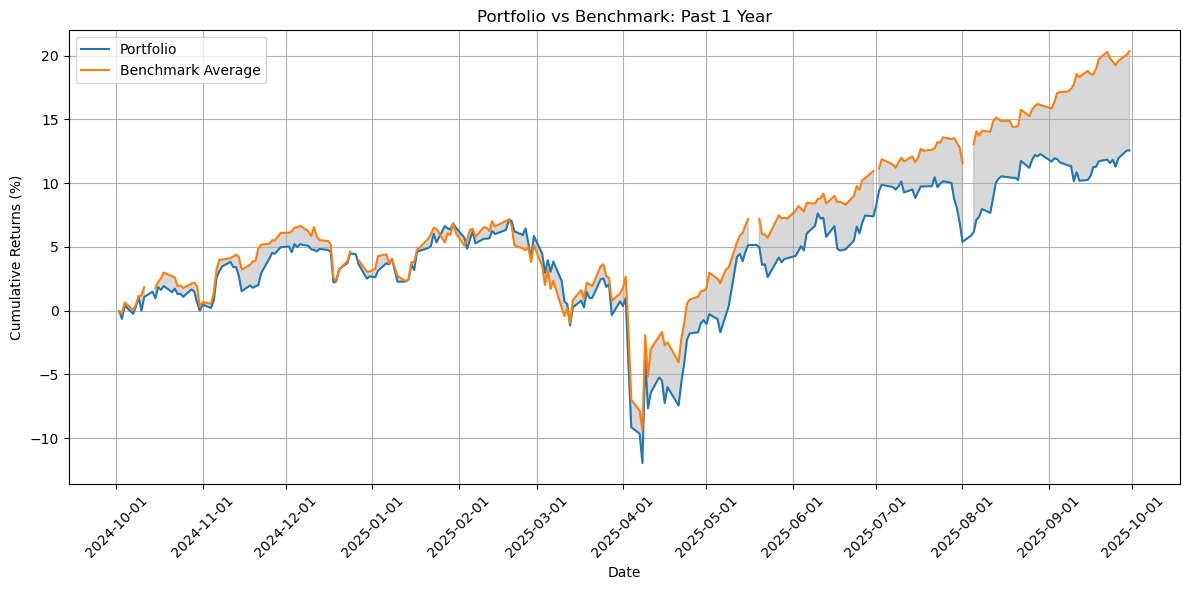

In [113]:
# Calculate portfolio daily returns 
# Get daily returns for final portfolio tickers
portfolio_tickers = final_portfolio["Ticker"].tolist()
portfolio_weights = final_portfolio["Weight"].values / 100 

# Filter close_prices for the portfolio tickers
portfolio_close = close_prices[portfolio_tickers]


# Calculate daily returns
portfolio_daily_returns = portfolio_close.pct_change().dropna()

# Weighted portfolio returns
weighted_returns = (portfolio_daily_returns * portfolio_weights).sum(axis=1)

# Cumulative returns
portfolio_cum_returns = (weighted_returns.cumsum()) * 100

# Benchmark cumulative returns (average of S&P500 and TSX)
benchmark_cum_returns = (sp_total_return + tsx_total_return) / 2

benchmark_cum_returns.index = benchmark_cum_returns.index.strftime('%Y-%m-%d')



# Reset index to get a 'Date' column and give Series a name
portfolio_df = portfolio_cum_returns.reset_index().rename(columns={0: "Portfolio", "index": "Date"})
benchmark_df = benchmark_cum_returns.rename("Benchmark").reset_index().rename(columns={"index": "Date"})

# Merge on Date
plot_df = pd.merge(portfolio_df, benchmark_df, on="Date", how="inner")

plot_df["Date"] = pd.to_datetime(plot_df["Date"])
print(plot_df)


# Plot 1-year cumulative returns 
plt.figure(figsize=(12,6))
plt.plot(plot_df["Date"], plot_df["Portfolio"], label="Portfolio")
plt.plot(plot_df["Date"], plot_df["Benchmark"], label="Benchmark Average")
plt.fill_between(plot_df["Date"], plot_df["Portfolio"], plot_df["Benchmark"], 
                 color="gray", alpha=0.3)
plt.title("Portfolio vs Benchmark: Past 1 Year")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # one tick per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# --- Step 3: Plot next week (Nov 21, 2025 – Nov 28, 2025) ---
# Slice dates for the next week
next_week_mask = (plot_df["Date"] >= "2025-11-21") & (plot_df["Date"] <= "2025-11-28")
next_week_df = plot_df.loc[next_week_mask]

plt.figure(figsize=(12,6))
plt.plot(next_week_df["Date"], next_week_df["Portfolio"], label="Portfolio")
plt.plot(next_week_df["Date"], next_week_df["Benchmark"], label="Benchmark Average")
plt.title("Portfolio vs Benchmark: Nov 21, 2025 – Nov 28, 2025")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True)

# Format x-axis: daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
